In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

all_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")
all_repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")
all_user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_user.parquet")

all_pr_df.head()


,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
0,3264016139,1688,`metta code` --> `metta clip` and additional p...,Remove unused `root_key` variable to fix ruff ...,Claude_Code,37011,jacklionheart,closed,2025-07-25T18:15:36Z,2025-07-25T19:17:23Z,2025-07-25T19:17:23Z,8.439884e+08,https://api.github.com/repos/Metta-AI/metta,https://github.com/Metta-AI/metta/pull/1688
1,3264021033,41,feat: Comprehensive ruff error resolution with...,## 🎯 Mission Accomplished: 100% Ruff Error Res...,Claude_Code,131842369,Draco3310,open,2025-07-25T18:17:57Z,None,None,9.920635e+08,https://api.github.com/repos/Draco3310/Gal-Fri...,https://github.com/Draco3310/Gal-Friday2/pull/41
2,3264042289,1600,Add Evals frontend implementation plan and HTM...,\nCreate comprehensive implementation plan for...,Claude_Code,6766889,justicart,closed,2025-07-25T18:26:15Z,2025-07-25T23:19:14Z,None,9.267118e+08,https://api.github.com/repos/bolt-foundry/bolt...,https://github.com/bolt-foundry/bolt-foundry/p...
3,3264042318,1601,Add 4 new BfDs components for Evals interface ...,\nPhase 1 component creation for the Evals fro...,Claude_Code,6766889,justicart,closed,2025-07-25T18:26:16Z,2025-07-25T23:19:11Z,None,9.267118e+08,https://api.github.com/repos/bolt-foundry/bolt...,https://github.com/bolt-foundry/bolt-foundry/p...
4,3264067496,3,🚀 Complete Frontend-Backend API Integration wi...,## 🎯 Summary\n\nThis PR completes the **fronte...,Claude_Code,42357482,twitchyvr,closed,2025-07-25T18:39:14Z,2025-07-25T18:48:47Z,2025-07-25T18:48:47Z,1.025871e+09,https://api.github.com/repos/twitchyvr/Spaghetti,https://github.com/twitchyvr/Spaghetti/pull/3


In [18]:
all_pr_df["created_at"] = pd.to_datetime(all_pr_df["created_at"])
all_user_df["created_at"] = pd.to_datetime(all_user_df["created_at"])


In [19]:
user_pr_count = all_pr_df.groupby("user_id").size().reset_index(name="num_prs")


In [20]:
user_agents = all_pr_df.groupby("user_id")["agent"].nunique().reset_index(name="num_agents_used")


In [21]:
user_main_agent = all_pr_df.groupby("user_id")["agent"].agg(lambda x: x.value_counts().idxmax()).reset_index(name="main_agent")


In [22]:
user_repos = all_pr_df.groupby("user_id")["repo_id"].nunique().reset_index(name="repos_contributed")


In [ ]:
all_pr_df["created_at"] = pd.to_datetime(all_pr_df["created_at"])

pr_dates = all_pr_df.groupby("user_id")["created_at"].agg(["min", "max", "count"])

# diferencia en días
pr_dates["days_active"] = (pr_dates["max"] - pr_dates["min"]).dt.days

# evitar división por 0
pr_dates["days_active"] = pr_dates["days_active"].clip(lower=1)

# pasar días → meses (promedio 30.44 días por mes)
pr_dates["months_active"] = pr_dates["days_active"] / 30.44

pr_dates["prs_per_month"] = pr_dates["count"] / pr_dates["months_active"]

pr_dates = pr_dates.reset_index()[["user_id", "prs_per_month"]]

pr_dates.head()


,user_id,prs_per_month
0,17,6.873548
1,19,60.880000
2,27,5.534545
3,70,30.440000
4,93,30.440000


In [27]:
all_user_df["created_at"] = pd.to_datetime(all_user_df["created_at"]).dt.tz_localize(None)

user_account_age = all_user_df.copy()

now = pd.Timestamp.now()

user_account_age["account_age_days"] = (now - user_account_age["created_at"]).dt.days

# Convertir a años (promedio año = 365.25 días)
user_account_age["account_age_years"] = user_account_age["account_age_days"] / 365.25

user_account_age = user_account_age[["id", "account_age_years"]]

user_account_age.head()


,id,account_age_years
0,149159513.0,2.072553
1,86906973.0,4.386037
2,36679210.0,7.753593
3,201261210.0,0.731006
4,22735204.0,9.117043


In [28]:
user_features = all_user_df.merge(user_pr_count, left_on="id", right_on="user_id", how="left")
user_features = user_features.merge(user_agents, on="user_id", how="left")
user_features = user_features.merge(user_main_agent, on="user_id", how="left")
user_features = user_features.merge(user_repos, on="user_id", how="left")
user_features = user_features.merge(pr_dates, on="user_id", how="left")
user_features = user_features.merge(user_account_age, left_on="id", right_on="id", how="left")

user_features = user_features.fillna(0)
user_features.head()


,id,login,followers,following,created_at,user_id,num_prs,num_agents_used,main_agent,repos_contributed,prs_per_month,account_age_years
0,149159513.0,00012122Cs,0.0,0.0,2023-10-27 10:22:50,149159513.0,3.0,1.0,OpenAI_Codex,1.0,91.32,2.072553
1,86906973.0,000Sean000,0.0,2.0,2021-07-04 07:05:40,86906973.0,1.0,1.0,OpenAI_Codex,1.0,30.44,4.386037
2,36679210.0,000alen,46.0,106.0,2018-02-20 21:00:55,36679210.0,2.0,1.0,Cursor,1.0,60.88,7.753593
3,201261210.0,000qhrey,0.0,1.0,2025-02-28 16:53:21,201261210.0,2.0,1.0,OpenAI_Codex,2.0,60.88,0.731006
4,22735204.0,00125495,0.0,1.0,2016-10-10 01:24:34,22735204.0,1.0,1.0,Cursor,1.0,30.44,9.117043


In [29]:
agent_distribution = all_pr_df.groupby("agent")["user_id"].nunique().reset_index(name="num_users")
agent_distribution


,agent,num_users
0,Claude_Code,1643
1,Copilot,379
2,Cursor,9658
3,Devin,1
4,OpenAI_Codex,61653


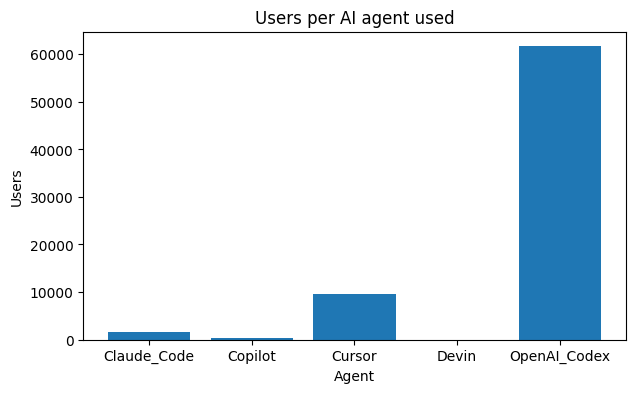

In [30]:
plt.figure(figsize=(7,4))
plt.bar(agent_distribution["agent"], agent_distribution["num_users"])
plt.title("Users per AI agent used")
plt.xlabel("Agent")
plt.ylabel("Users")
plt.show()


In [31]:
grouped = user_features.groupby("main_agent")[["followers", "account_age_years", "num_prs", "prs_per_month"]].mean()
grouped


,followers,account_age_years,num_prs,prs_per_month
main_agent,,,,
0,0.000000,0.000000,0.000000,0.000000
Claude_Code,91.015225,9.539159,3.438754,34.774969
Copilot,51.450000,6.410758,1.629412,39.045243
Cursor,38.458094,5.129735,3.512826,48.567023
Devin,0.000000,1.809719,29746.000000,4153.524037
OpenAI_Codex,18.227122,5.906447,13.292792,81.370928


rq2

In [32]:
repo_activity = all_pr_df.groupby("repo_id").size().reset_index(name="num_ai_prs")


In [33]:
repo_stats = all_repo_df.merge(repo_activity, left_on="id", right_on="repo_id", how="left")
repo_stats = repo_stats.fillna(0)
repo_stats.head()


,id,url,license,full_name,language,forks,stars,repo_id,num_ai_prs
0,987641962,https://api.github.com/repos/1010-dev/senjudev...,0,1010-dev/senjudev-site,TypeScript,1.0,0.0,9.876420e+08,1
1,990249393,https://api.github.com/repos/106-/HellSinkerWa...,0,106-/HellSinkerWallPaper,Java,0.0,0.0,9.902494e+08,2
2,1009549206,https://api.github.com/repos/1genadam/tileshop...,0,1genadam/tileshop-rag,Python,0.0,0.0,1.009549e+09,1
3,983546765,https://api.github.com/repos/1kimnet/ETL-pipeline,0,1kimnet/ETL-pipeline,Python,0.0,0.0,9.835468e+08,37
4,1024190983,https://api.github.com/repos/20m61/lightningta...,0,20m61/lightningtalk-circle,JavaScript,0.0,0.0,1.024191e+09,7


In [34]:
repo_stats[["num_ai_prs", "stars", "forks"]].corr()


,num_ai_prs,stars,forks
num_ai_prs,1.000000,0.006065,0.003811
stars,0.006065,1.000000,0.711401
forks,0.003811,0.711401,1.000000


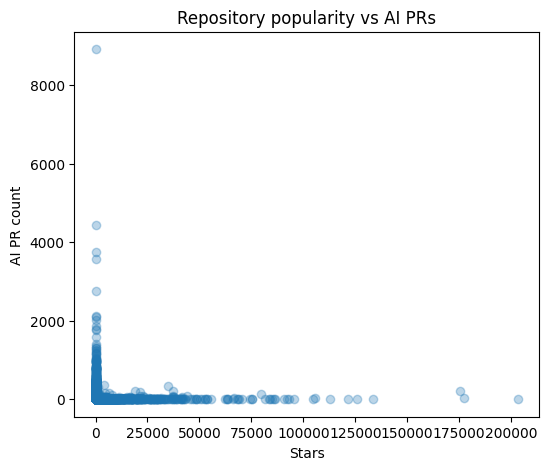

In [35]:
plt.figure(figsize=(6,5))
plt.scatter(repo_stats["stars"], repo_stats["num_ai_prs"], alpha=0.3)
plt.xlabel("Stars")
plt.ylabel("AI PR count")
plt.title("Repository popularity vs AI PRs")
plt.show()


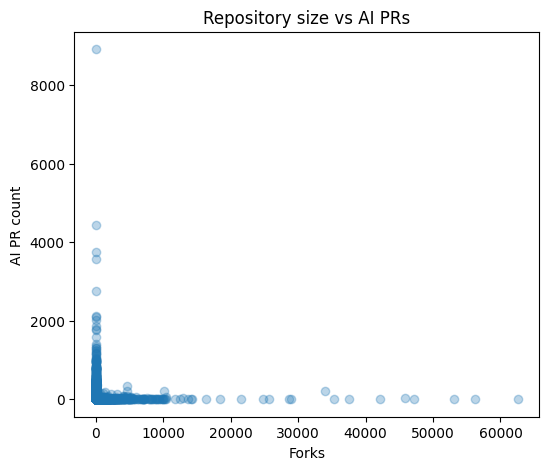

In [36]:
plt.figure(figsize=(6,5))
plt.scatter(repo_stats["forks"], repo_stats["num_ai_prs"], alpha=0.3)
plt.xlabel("Forks")
plt.ylabel("AI PR count")
plt.title("Repository size vs AI PRs")
plt.show()


In [37]:
features_for_clustering = user_features[[
    "followers",
    "following",
    "account_age_years",
    "num_prs",
    "prs_per_month",
    "num_agents_used",
    "repos_contributed"
]].copy()

scaler = StandardScaler()
X = scaler.fit_transform(features_for_clustering)


In [38]:
kmeans = KMeans(n_clusters=4, random_state=42)
user_features["cluster"] = kmeans.fit_predict(X)

user_features[["login", "followers", "num_prs", "cluster"]].head()


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


,login,followers,num_prs,cluster
0,00012122Cs,0.0,3.0,0
1,000Sean000,0.0,1.0,0
2,000alen,46.0,2.0,2
3,000qhrey,0.0,2.0,0
4,00125495,0.0,1.0,2


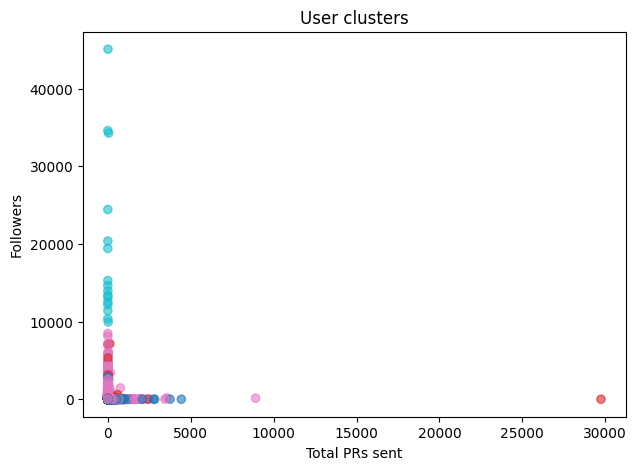

In [39]:
plt.figure(figsize=(7,5))
plt.scatter(user_features["num_prs"], user_features["followers"], c=user_features["cluster"], cmap="tab10", alpha=0.6)
plt.xlabel("Total PRs sent")
plt.ylabel("Followers")
plt.title("User clusters")
plt.show()


In [40]:
cluster_summary = user_features.groupby("cluster")[[
    "followers", "following", "account_age_years",
    "num_prs", "prs_per_month", "num_agents_used",
    "repos_contributed"
]].mean()

cluster_summary


,followers,following,account_age_years,num_prs,prs_per_month,num_agents_used,repos_contributed
cluster,,,,,,,
0,3.432006,4.140017,2.920595,10.969960,74.935686,0.989286,1.310473
1,96.155996,36.675383,7.929470,56.129847,45.605511,2.031560,8.321010
2,39.769628,24.473229,10.765165,12.312374,78.236755,1.000000,1.373923
3,19068.875000,110.312500,13.901095,7.312500,34.253142,1.000000,2.187500
